### Stock Forecaster Test 2

In [1]:
### Libraries and Packages

In [2]:
# https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
# https://www.sciencedirect.com/science/article/pii/S2666827022000378
# https://www.sciencedirect.com/science/article/pii/S2666827022000378
from lib.forecast2 import StockForecast
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime

import copy
from pathlib import Path
import warnings

from lib.scraper import StockScraper

In [8]:
n = datetime.now()
print(n), print(n.timestamp())

2023-06-29 17:53:20.856922
1688086400.856922


(None, None)

In [15]:

                
df["Date"] = pd.date_ran

KeyboardInterrupt: 

In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np

import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
# https://fred.stlouisfed.org/series/UNRATE

effr_data = pd.read_csv(f"macroeconomics_data/EFFR.csv")
umcsent_data = pd.read_csv(f"macroeconomics_data/UMCSENT.csv")
unrate_data = pd.read_csv(f"macroeconomics_data/UNRATE.csv")

macro_data = effr_data.merge(umcsent_data, on="DATE",how="left" )
macro_data = macro_data.merge(unrate_data, on="DATE",how="left" )
macro_data["Date"] = macro_data["DATE"]
macro_data = macro_data.drop(columns=["DATE"])

In [5]:
macro_data["EFFR"] = macro_data["EFFR"].replace(".",np.nan).fillna(method="bfill")
macro_data["UMCSENT"] = macro_data["UMCSENT"].fillna(method="ffill")
macro_data["UNRATE"] = macro_data["UNRATE"].fillna(method="ffill")
print(macro_data.shape)
macro_data.tail()

(5996, 4)


,EFFR,UMCSENT,UNRATE,Date
5991,5.07,62.0,3.7,2023-06-20
5992,5.07,62.0,3.7,2023-06-21
5993,5.07,62.0,3.7,2023-06-22
5994,5.07,62.0,3.7,2023-06-23
5995,5.07,62.0,3.7,2023-06-26


In [6]:
# GET SPY HISTORICAL
TICKER = "amd"
scraper = StockScraper(TICKER, interval="1d", period="10y")
scraper.from_yahoo()
sdata = scraper.data
sdata["Date"] = sdata.index.strftime("%Y-%m-%d")
sdata = sdata.reset_index(drop=True)[["Date", "Close", "Volume", "Stock Splits"]]

print(f"SPY shape = {sdata.shape}")

# GET VIX HISTORICAL
scraper = StockScraper("^VIX", interval="1d", period="10y")
scraper.from_yahoo()
vix = scraper.data[["Close"]].rename(columns={"Close": "VIX"})
vix["Date"] = vix.index.strftime("%Y-%m-%d")
vix = vix.reset_index(drop=True)

print(f"VIX shape = {vix.shape}")

# GET DOLLAR INDEX HISTORICAL
scraper = StockScraper("DX-Y.NYB", interval="1d", period="15y")
scraper.from_yahoo()

dix = scraper.data[["Close"]].rename(columns={"Close": "Dollar Index"})
dix["Date"] = dix.index.strftime("%Y-%m-%d")
dix = dix.reset_index(drop=True)

print(f"DIX shape = {dix.shape}")

mdata = vix.merge(dix, on="Date",how="left" )
sdata = sdata.merge(mdata, on="Date", how="left")
print(f"MERGE shape = {sdata.shape}")


# GET OPTIONS DATA
if False:
    options_cols = ["Date", "Imp Vol", "Put/Call Vol", "Options Vol", "Put/Call OI"]
    options_data = pd.read_csv(f"options_data/{TICKER}.csv")
    sdata = sdata.merge(options_data[options_cols], on="Date",how="inner" )
    print(f"Options shape = {options_data.shape}")
    print(f"MERGE shape = {sdata.shape}")
    for col in ["Imp Vol"]:
        sdata[col] = sdata[col].str.rstrip('%').astype('float') / 100.0


stock_data = sdata.merge(macro_data, on="Date", how="left")
stock_data["time_idx"] = range(stock_data.shape[0])
stock_data["chart"] = TICKER

stock_data["Dollar Index"] = stock_data["Dollar Index"].fillna(method="bfill")

print(f"macro shape = {macro_data.shape}")
print(f"MERGE shape = {sdata.shape}")
    
stock_data.head(20)

SPY shape = (2517, 4)
VIX shape = (2517, 2)
DIX shape = (3778, 2)
MERGE shape = (2517, 6)
macro shape = (5996, 4)
MERGE shape = (2517, 6)


,Date,Close,Volume,Stock Splits,VIX,Dollar Index,EFFR,UMCSENT,UNRATE,time_idx,chart
0,2013-06-26,4.14,19841200,0.0,17.209999,82.949997,0.09,84.5,7.5,0,amd
1,2013-06-27,4.08,17426100,0.0,16.860001,82.910004,0.09,84.5,7.5,1,amd
2,2013-06-28,4.08,13329600,0.0,16.860001,83.169998,0.07,84.5,7.5,2,amd
3,2013-07-01,4.10,10712200,0.0,16.370001,82.980003,0.10,85.1,7.3,3,amd
4,2013-07-02,3.97,17766600,0.0,16.440001,83.540001,0.10,85.1,7.3,4,amd
5,2013-07-03,4.06,11315900,0.0,16.200001,83.230003,0.10,85.1,7.3,5,amd
6,2013-07-05,4.07,8965400,0.0,14.890000,84.419998,0.10,85.1,7.3,6,amd
7,2013-07-08,4.00,16930900,0.0,14.780000,84.199997,0.10,85.1,7.3,7,amd
8,2013-07-09,4.05,9550900,0.0,14.350000,84.580002,0.10,85.1,7.3,8,amd
9,2013-07-10,3.98,19122800,0.0,14.210000,84.040001,0.09,85.1,7.3,9,amd


### Load Raw Stock Data

In [7]:
stock_data[stock_data["Dollar Index"].isnull()]

,Date,Close,Volume,Stock Splits,VIX,Dollar Index,EFFR,UMCSENT,UNRATE,time_idx,chart


### More Data

with more information the assumption is the model will get better at predictions.
1. fed meetings
2. holidays
3. stock splits
4. options volume
5. options put/call agg volume

It might also be interesting to train several stocks / indexes into one model

### Create Model Datasets

In [8]:
# https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/building.html#passing-data

max_prediction_length = 6  # forecast 6 months
max_encoder_length = 30  # use 24 months of history
max_epochs = 50
batch_size = 32

# since the datetime is not periodic, we're adding a 
# fixed size incrementation for each data cell
data = stock_data

training_cutoff = data["time_idx"].max() - max_prediction_length

torch_device = "cpu"
tdevice = torch.device(torch_device)
    
# create trainer; normalize data, set weights, create tensors, validation - the whole 9
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",  # ["Close"],
    
    group_ids=["chart"],
    weight=None,
    
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length,  # allow predictions without history
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    
    static_reals=[],
    time_varying_known_categoricals=[],

    time_varying_unknown_reals=[
        # "Imp Vol", "Put/Call Vol", "Options Vol", "Put/Call OI", 
        "EFFR", "UMCSENT", "UNRATE", "Dollar Index", "VIX",  "Close", "Volume"
    ],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    
    variable_groups={},
    lags={},
    static_categoricals=["chart"],
    
    constant_fill_strategy={},
    
    # TorchNormalizer, GroupNormalizer, NaNLabelEncoder, EncoderNormalizer
    # MultiNormalizer
    target_normalizer=GroupNormalizer(
       groups=["chart"], transformation="softplus"
    ), 


    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
)

### Train the model

In [9]:
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = batch_size
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [10]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(10.8617, device='mps:0')

### Tuning the model parameters

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 80.0k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.03548133892335756
Restoring states from the checkpoint path at /Users/dbell/Documents/mycode/stockai/.lr_find_84f7d903-5998-45df-8e64-ea6d0966ba00.ckpt
Restored all states from the checkpoint at /Users/dbell/Documents/mycode/stockai/.lr_find_84f7d903-5998-45df-8e64-ea6d0966ba00.ckpt


suggested learning rate: 0.03548133892335756


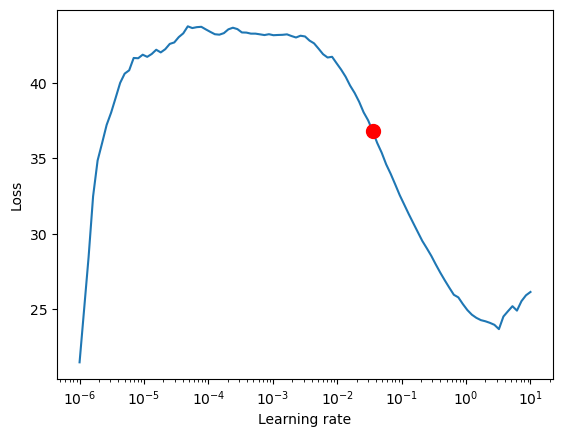

In [11]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator=torch_device,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.6943055468697653,
)

"""
    'gradient_clip_val': 0.016723475628684332, 
    'hidden_size': 12, 
    'dropout': 0.20273552774959722, 
    'hidden_continuous_size': 9, 
    'attention_head_size': 4, 
    'learning_rate': 0.010477429830518623
"""
"""
Trial 0 finished with value: 56.48472213745117 and parameters: 
{
    'gradient_clip_val': 0.6943055468697653, 
    'hidden_size': 35, 
    'dropout': 0.24100408480680044, 
    'hidden_continuous_size': 9, 
    'attention_head_size': 3, 
    'learning_rate': 0.003134745802918898
}. Best is trial 0 with value: 56.48472213745117.
"""
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.003134745802918898,
    hidden_size=35,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.24100408480680044,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=9,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [12]:
# export PYTORCH_ENABLE_MPS_FALLBACK=1

import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=max_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-06-28 17:18:19,480] A new study created in memory with name: no-name-4efa81e3-1155-4fb8-832b-e133e3d41858
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-06-28 17:27:49,904] Trial 0 finished with value: 5.527894973754883 and parameters: {'gradient_clip_val': 0.07957531048227721, 'hidden_size': 73, 'dropout': 0.12144553040744104, 'hidden_continuous_size': 28, 'attention_head_size': 1, 'learning_rate': 0.003993726374541425}. Best is trial 0 with value: 5.527894973754883.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-06-28 17:37:55,086] Trial 1 finished with value: 10.788082122802734 and parameters: {'gradient_clip_val': 0.058791553562941, 'hidden_size': 101, 'dropou

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Model Training

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator=torch_device,
    enable_model_summary=True,
    gradient_clip_val=0.23671769794503256,
    # limit_train_batches=50,  # coment in for training, running validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

"""
Trial 1 finished with value: 2.512352466583252 and parameters: 
{
    'gradient_clip_val': 0.23671769794503256, 
    'hidden_size': 14, 
    'dropout': 0.17934389477113102, 
    'hidden_continuous_size': 12, 
    'attention_head_size': 2, 
    'learning_rate': 0.0016975585990462374
}. Best is trial 1 with value: 2.512352466583252.
"""

"""
Trial 0 finished with value: 3.0804049968719482 and parameters: {
    'gradient_clip_val': 0.018173198922575805, 
    'hidden_size': 19, 
    'dropout': 0.1691311061383082, 
    'hidden_continuous_size': 11, 
    'attention_head_size': 2, 
    'learning_rate': 0.001059429134884675
}. Best is trial 0 with value: 3.0804049968719482.
"""

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001059429134884675,
    hidden_size=40,
    attention_head_size=2,
    dropout=0.1691311061383082,
    hidden_continuous_size=12,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
best_model_path

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, fast_dev_run=False)
STOCK_TICKERS = ["spy"]

In [ ]:
for idx in range(len(STOCK_TICKERS)):  # plot 10 examples
    plt = best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.legend("hello")
    plt.show()

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(indices.shape[0]):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)